In [1]:
# Importation of libraries

import math
import matplotlib 
import sys
sys.path.append('/home/ballerini/Desktop/NEWstudy/Programs/')
import numpy as np
import numpy.linalg as nplin
import numpy.polynomial.polynomial as nppol

import matplotlib.pyplot as plt
from scipy.optimize import fsolve



from matplotlib.colors import LogNorm 
import os
from RMs_module_collection_GB import *
from M_bib_GB import * 

from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

from mpl_toolkits.axes_grid1 import *
from mpl_toolkits.axisartist import *

%matplotlib inline
%matplotlib widget

import pickle


import Functions_GIU


plt.style.use('/home/ballerini/Desktop/grafici articoli/paper_plot.mplstyle')

/home/ballerini/venv/lib/python3.10/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


### Inputs MMS:
#### We interpolate all the data, with some precautions to avoid accidents due to oversampling) , for semplicity in working.

In [2]:


import os #ajout LR

day = '20151228'
hour = '221157_20'

data_path='/home/ballerini/Desktop/Novembre22/Smoothing pre download'
data_path='/home/ballerini/Desktop/Novembre22/NEWDATA'

wheredataare = data_path+'/'+day+'/' + hour


N, time, Br, Vir, Ni, Ver, Ne, rhoVir, rhoVer, Er, Pi_tensor, Pe_tensor, kvec, kvecr, dt, coord= Functions_GIU.get_data(day, hour, wheredataare)

            LES DONNEES SONT CHARGEES


In [3]:
##############Intervalles d'étude#############################
# Intervalle global
tmin=np.min(time)
tmax=np.max(time)
nrange_glob=range(N)
nglob=np.arange(N)

#ZOOM standard
###############
tminz=0.1
tmaxz=tmax-0.1
Nmaxz=int(float(N)*(tmaxz-tmin)/(tmax-tmin))
Nminz=int(float(N)*(tminz-tmin)/(tmax-tmin))
Nz=Nmaxz-Nminz
nrangez=range(Nminz,Nmaxz)
trangez=time[nrangez]
n_inf=range(0, Nminz)
n_sup=range(Nmaxz, N)
kvec0=np.mean(kvec[:,nrangez], axis=1)
kvec0r=np.reshape(kvec0,(4,3))

#ZOOM4 (centre)
######
tminz4=5.3
tmaxz4=6.
Nmaxz4=int(float(N)*(tmaxz4-tmin)/(tmax-tmin))
Nminz4=int(float(N)*(tminz4-tmin)/(tmax-tmin))
Nz4=Nmaxz4-Nminz4
nrangez4=range(Nminz4,Nmaxz4)
trangez4=time[nrangez4]

#ZOOM central crossing interval
######
tminz5=7.
tmaxz5=11.

Nmaxz5=int(float(N)*(tmaxz5-tmin)/(tmax-tmin))
Nminz5=int(float(N)*(tminz5-tmin)/(tmax-tmin))
Nz5=Nmaxz5-Nminz5
nrangez5=range(Nminz5,Nmaxz5)
trangez5=time[nrangez5]

### Normal smoothed with a moving window of 10 times points

In [4]:
Nw=10
vB_smooth, tkeep_B, keep_B, n_B, u_B,Vn_B, X_B, d_B =Functions_GIU.B_normal(Br, Nw, N, dt,
                    nrangez, time, n_inf, n_sup, coord, kvecr, nrangez4)

vB_smooth_mod=np.linalg.norm(vB_smooth, axis=0)

nb_remove= 474  nb_remove1= 466  nb_remove2= 30  nb_remove3= 234  nb_remove4= 17


In [5]:
# COURANT

J=np.zeros((3,N))

for t in nrangez:
    Bprim_mod=X_B[t]/d_B[t]
    Bprim=Bprim_mod*u_B[:,t]
    J[:,t]=np.cross(n_B[:,t], Bprim)
    


In [6]:
# COURANT

J=np.zeros((3,N))
Bprim_array=np.zeros((3,N))

for t in nrangez:
    Bprim_mod=X_B[t]/d_B[t]
    Bprim=Bprim_mod*u_B[:,t]
    Bprim_array[:,t]=Bprim_mod*u_B[:,t]

    J[:,t]=np.cross(n_B[:,t], Bprim)

m_i=1.67*1e-27
m_e=9.1093*1e-31
q_e=1.6e-19



In [7]:
Jx=np.zeros(N)
Jy=np.zeros(N)

n_mean=np.mean(n_B[:,nrangez5], axis=1)
n_mean=n_mean/nplin.norm(n_mean, axis=0)

ex=[0,1,0]
ey=[0,0,1]



eyt=-np.cross(ex,n_mean)
eyt=eyt/nplin.norm(eyt)

ext=np.cross(eyt,n_mean)
ext=ext/nplin.norm(ext)

print(n_mean,ext,eyt)

[ 0.77594587 -0.52415147 -0.35096047] [ 0.47757304  0.85162506 -0.21600638] [ 0.41210679 -0.          0.91113555]


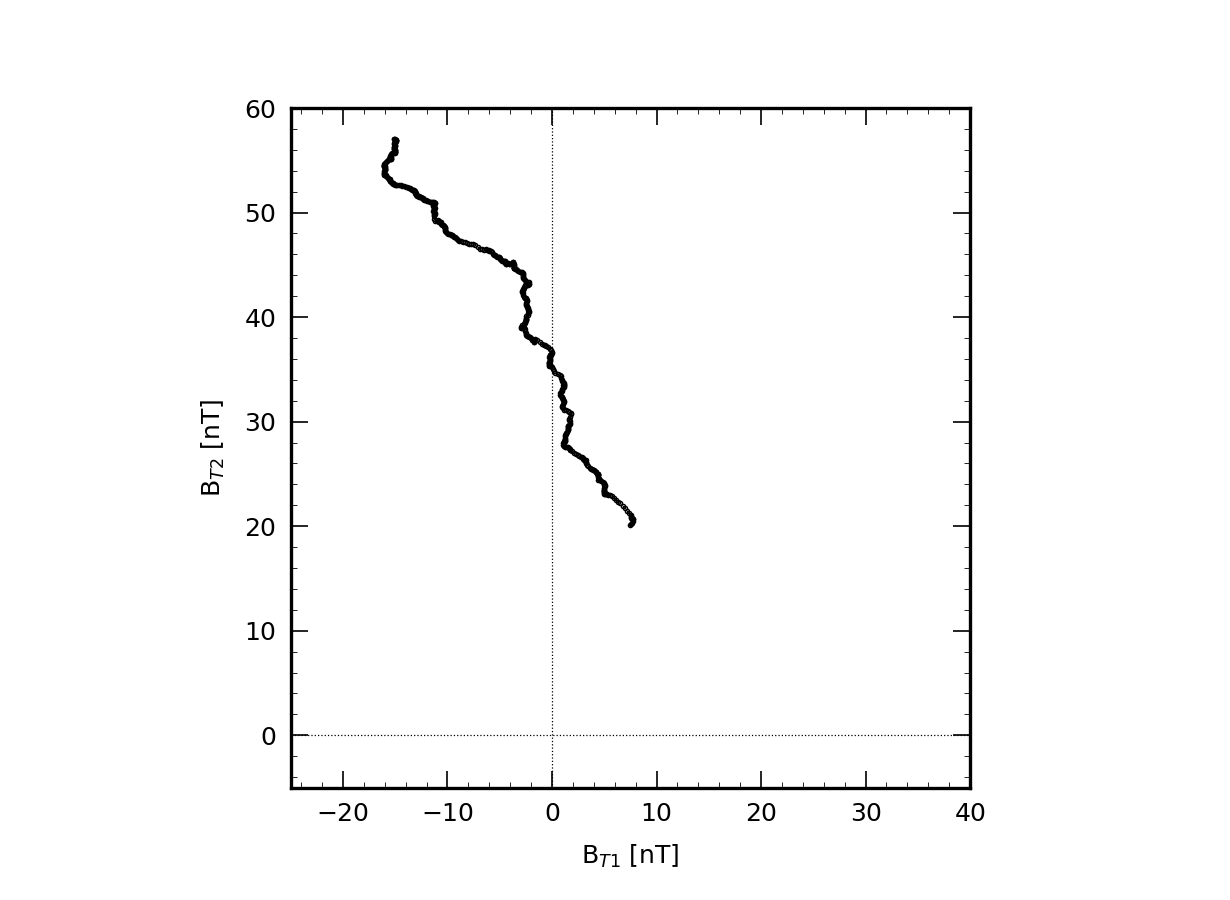

In [8]:
# Hodogramme du courant dans le plan tangentiel moyen


Bx=np.zeros(N)
By=np.zeros(N)



for t in nrangez:
    
    Bx[t]=np.dot(np.mean(Br[:,:,t],axis=0), ext)
    By[t]=np.dot(np.mean(Br[:,:,t],axis=0), eyt)
    

 #########################################
fig,ax=plt.subplots()


plt.scatter(Bx[nrangez5]*1e9, By[nrangez5]*1e9, color="black",marker='.', s=0.5)


ax.set_aspect('equal')
plt.xlabel('B$_{T1}$ [nT]')
plt.ylabel('B$_{T2}$ [nT]')

plt.axhline(y=0, color="black",linestyle=':')
plt.axvline(x=0, color="black",linestyle=':')



plt.ylim([-5, 60])
plt.xlim([-25, 40])
plt.show()

# Momenutum equation part

In [9]:
Tsum_nxy=np.zeros((3,N)) 
JxB_nxy=np.zeros((3,N)) 
JcxB_nxy=np.zeros((3,N)) 
J1xB_nxy=np.zeros((3,N)) 
divPi_nxy=np.zeros((3,N)) 
divPe_nxy=np.zeros((3,N))

mu0=4*np.pi*1e-7
gradB=np.einsum('sit,sjt->ijt', kvecr, Br)

JcrossB=np.cross(J/mu0,np.mean(Br,axis=0), axisa=0, axisb=0, axisc=0)
#JccrossB=np.cross(Jc,np.mean(Br,axis=0), axisa=0, axisb=0, axisc=0)
#J1crossB=np.cross(J1,np.mean(Br,axis=0), axisa=0, axisb=0, axisc=0)
gradVir=np.einsum('sit,sjt->ijt',kvecr, Vir)
V_gradVi=np.einsum('it,ijt->jt',np.mean(Vir,axis=0),gradVir)
gradVer=np.einsum('sit,sjt->ijt',kvecr, Ver)
V_gradVe=np.einsum('it,ijt->jt',np.mean(Ver,axis=0),gradVer)
t2=np.mean(Ni,axis=0)*m_i*V_gradVi+np.mean(Ne,axis=0)*m_e*V_gradVe

dtVi=np.gradient(np.mean(Vir,axis=0),dt,axis=1)
dtVe=np.gradient(np.mean(Ver,axis=0),dt,axis=1)
t1=np.mean(Ni,axis=0)*m_i*dtVi+np.mean(Ne,axis=0)*m_e*dtVe
divPemean=np.einsum('sit,sijt->jt',kvecr, Pe_tensor)
divPmean=np.einsum('sit,sijt->jt',kvecr, Pi_tensor)
#divPmean=np.gradient(np.einsum('i,ikj->kj', n_mean, np.mean(Pi_tensor, axis=0)), dt, axis=1)/np.linalg.norm(Vn_best)


JB_smooth=np.zeros((3,N))
J1B_smooth=np.zeros((3,N))
JcB_smooth=np.zeros((3,N))

for t in nrangez:        
    minw = max(t-Nw, 0)
    maxw = min(t+Nw+1, N)
    wrange=np.arange(minw,maxw)
    JB_smooth[:,t]=np.mean(JcrossB[:,wrange],axis=1)
sum1=-JB_smooth+t1+t2+divPmean#+divP_Bmean
for t in nrangez:
    

    eyt1=-np.cross(ex,n_mean[:])
    eyt1=eyt1/nplin.norm(eyt1)
    ext1=np.cross(eyt1,n_mean[:])
    ext1=ext1/nplin.norm(ext1)
    Tsum_nxy[0,t]=np.dot((t1+t2)[:,t], n_B[:,t])
    Tsum_nxy[1,t]=np.dot((t1+t2)[:,t], ext1)
    Tsum_nxy[2,t]=np.dot((t1+t2)[:,t], eyt1)
    
    JxB_nxy[0,t]=np.dot(JB_smooth[:,t], n_B[:,t])
    JxB_nxy[1,t]=np.dot(JB_smooth[:,t], ext1)
    JxB_nxy[2,t]=np.dot(JB_smooth[:,t], eyt1)
    divPi_nxy[0,t]=np.dot(divPmean[:,t], n_B[:,t])
    divPi_nxy[1,t]=np.dot(divPmean[:,t], ext1)
    divPi_nxy[2,t]=np.dot(divPmean[:,t], eyt1)
    divPe_nxy[0,t]=np.dot(divPemean[:,t], n_B[:,t])
    divPe_nxy[1,t]=np.dot(divPemean[:,t], ext1)
    divPe_nxy[2,t]=np.dot(divPemean[:,t], eyt1)

In [10]:
#sum_nxy=Tsum_nxy-JxB_nxy+divPi_nxy+divPe_nxy
limits=[2e-14, 4e-15, 4e-15]
titles=['n','ext','eyt']


(7.000411, 10.9925985)

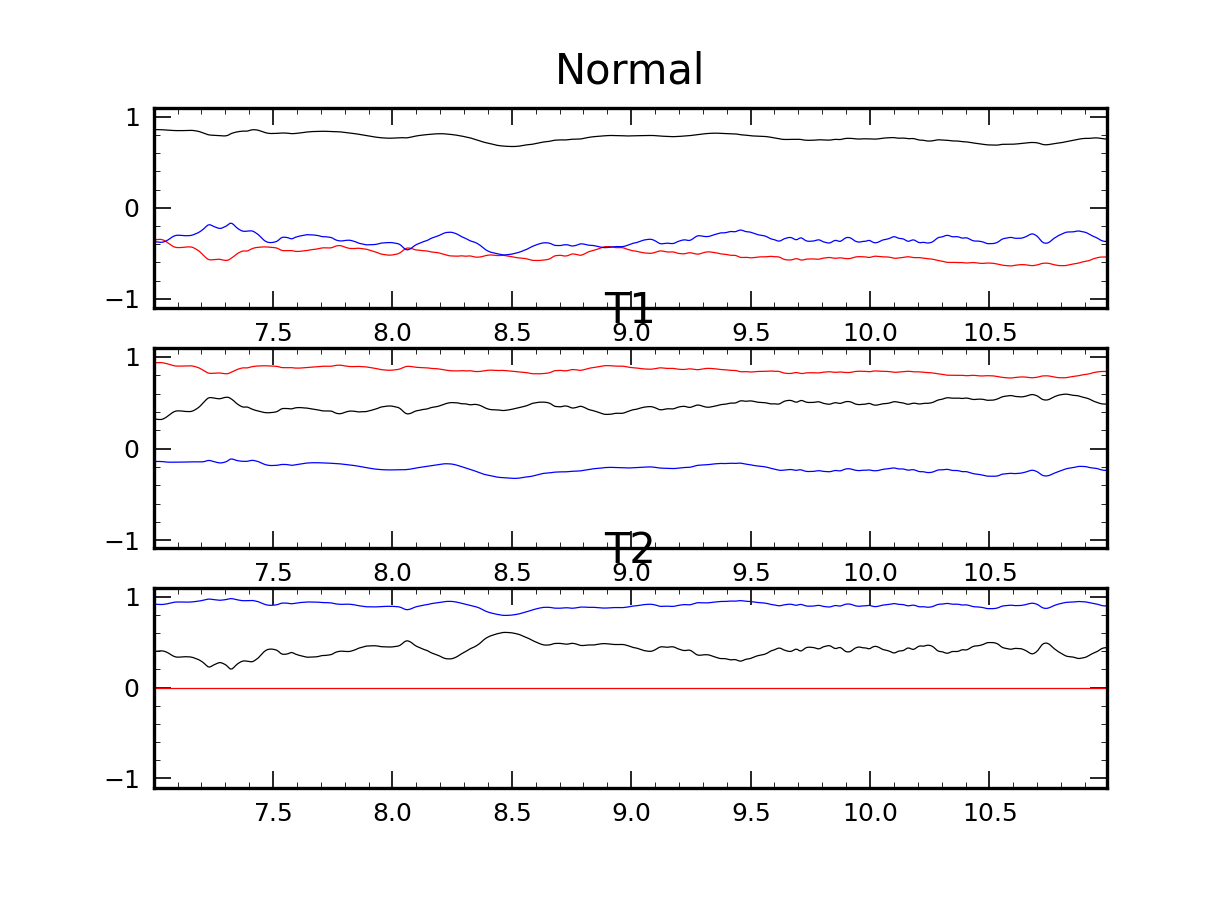

In [11]:
t1=np.zeros((3,N))
t2=np.zeros((3,N))
for t in nrangez:
    eyt1=-np.cross(ex,n_B[:,t])
    eyt1=eyt1/nplin.norm(eyt1)
    ext1=np.cross(eyt1,n_B[:,t])
    ext1=ext1/nplin.norm(ext1)
    t2[:,t]=eyt1
    t1[:,t]=ext1
plt.figure()
plt.subplot(3,1,1)
plt.plot(trangez,n_B[0,nrangez], color='black', label='x')
plt.plot(trangez,n_B[1,nrangez], color='red', label='y')
plt.plot(trangez,n_B[2,nrangez], color='blue', label='z')
plt.title('Normal')
plt.xlim([trangez5[0], trangez5[-1]])
plt.subplot(3,1,2)
plt.plot(trangez,t1[0,nrangez], color='black', label='x')
plt.plot(trangez,t1[1,nrangez], color='red', label='y')
plt.plot(trangez,t1[2,nrangez], color='blue', label='z')
plt.title('T1')
plt.xlim([trangez5[0], trangez5[-1]])
plt.subplot(3,1,3)
plt.plot(trangez,t2[0,nrangez], color='black', label='x')
plt.plot(trangez,t2[1,nrangez], color='red', label='y')
plt.plot(trangez,t2[2,nrangez], color='blue', label='z')
plt.title('T2')
plt.xlim([trangez5[0], trangez5[-1]])

In [12]:
trangez=trangez-trangez5[0]
trangez5=trangez5-trangez5[0]

/tmp/ipykernel_49287/1567073861.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[i])
/tmp/ipykernel_49287/1567073861.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[i], sharex = ax0)


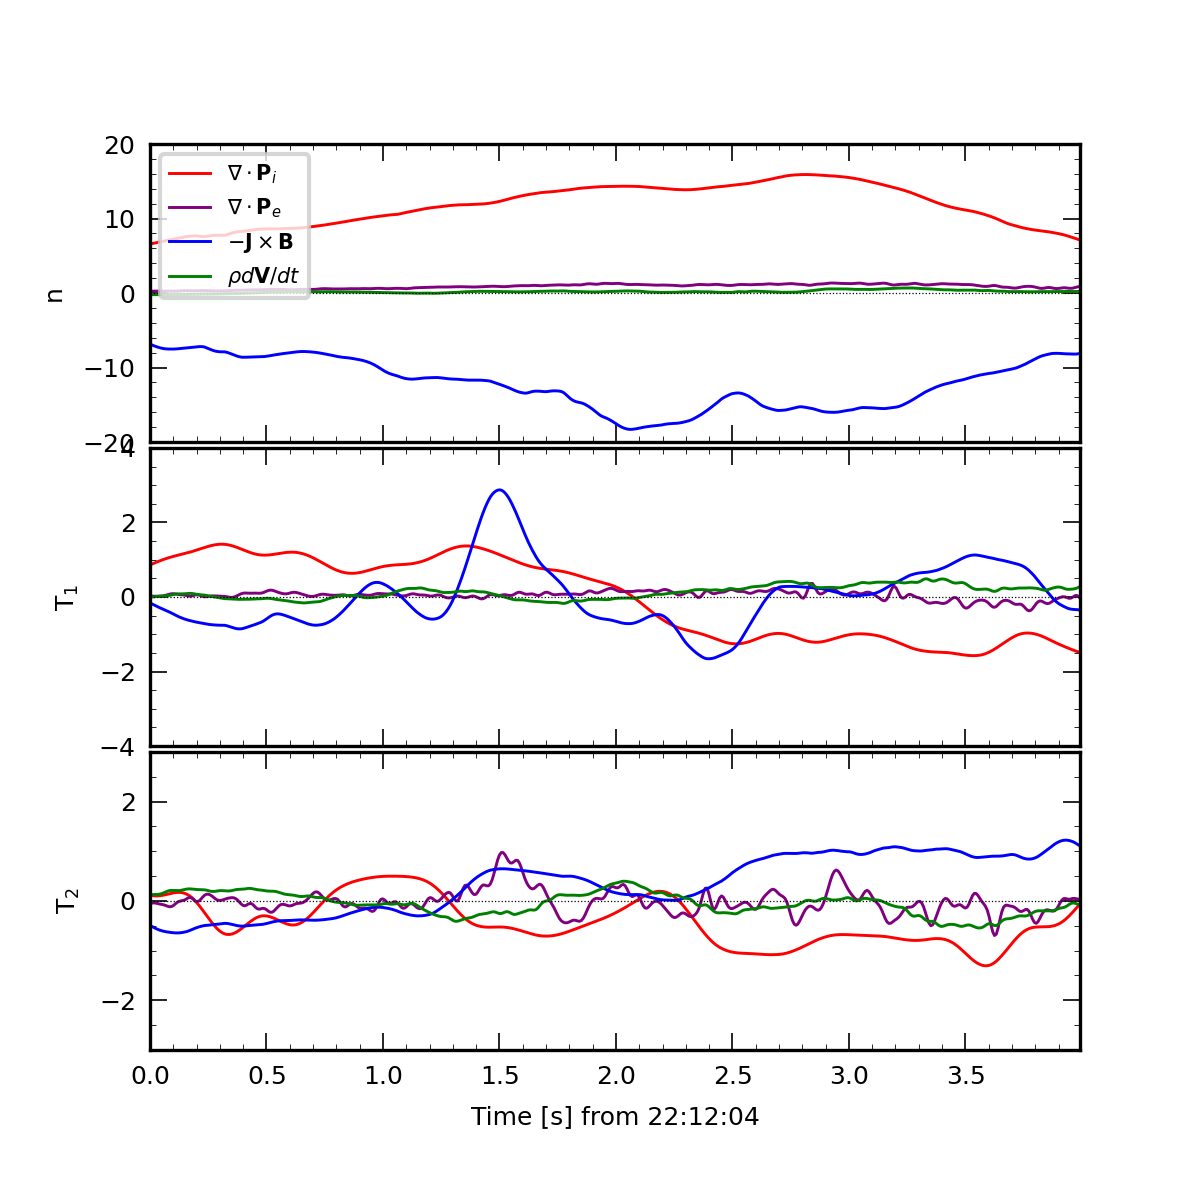

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=[4,4])
titles=['n','T$_1$','T$_2$']
limits=[2e-14, 4e-15, 4e-15]

limits=[2e-14, 4e-15, 3e-15]
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 1) 
for i in [2,1,0]:#range(3):
    if i!=2:
        ax0 = plt.subplot(gs[i], sharex = ax0)
    else:
        ax0 = plt.subplot(gs[i])
    ax0.set_ylabel(titles[i])
    i1,=plt.plot(trangez, divPi_nxy[i,nrangez]*1e15, color='red', label='$\\nabla\cdot\mathbf{P}_i$', lw=0.7)
    i2,=plt.plot(trangez, divPe_nxy[i,nrangez]*1e15, color='purple', label='$\\nabla\cdot\mathbf{P}_e$', lw=0.7)
    i3,=plt.plot(trangez, -JxB_nxy[i,nrangez]*1e15, color='blue', label='$-\\mathbf{J}\\times \mathbf{B}$', lw=0.7)
    i4,=plt.plot(trangez, Tsum_nxy[i,nrangez]*1e15, color='green', label='$mn d\\mathbf{V}/dt$', lw=0.7)
    plt.axhline(y = 0, color = 'black', linestyle = ':')
    plt.xlim([trangez5[0], trangez5[-1]])
    #ax0.xaxis.set_visible(False)
    if i in [0,1]:
        plt.setp(ax0.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Time [s] from 22:12:04')
    plt.ylim([-limits[i]*1e15, limits[i]*1e15])


plt.subplots_adjust(hspace=.02)
ax0 = plt.subplot(gs[0])

#ax0.xaxis.set_visible(True)
ax0 = plt.subplot(gs[0])
plt.legend([i1, i2, i3, i4],["$\\nabla\cdot\mathbf{P}_i$", "$\\nabla\cdot\mathbf{P}_e$", "$-\\mathbf{J}\\times \mathbf{B}$", "$\\rho d\\mathbf{V}/dt$"], loc='upper left')
#plt.savefig(fname='/home/ballerini/Desktop/grafici articoli/LetteraPRL/Momentum_NEW44.png', format='png',bbox_inches='tight') 
#plt.close()

In [14]:
Momentum1=divPi_nxy
Momentum2=divPe_nxy
Momentum3=-JxB_nxy
Momentum4=Tsum_nxy


# Ohm equation

In [15]:
dtB=np.gradient(np.mean(Br,axis=0), dt, axis=1)

U=(m_i*Vir+m_e*Ver)/(m_i+m_e)



UcrossB=np.cross(np.mean(Vir, axis=0),np.mean(Br,axis=0), axisa=0, axisb=0, axisc=0)
JcrossB=np.cross(J/mu0,np.mean(Br,axis=0), axisa=0, axisb=0, axisc=0)/(np.mean(Ni, axis=0)*q_e)
divPemean=np.einsum('sit,sijt->jt',kvecr, Pe_tensor)/(np.mean(Ni, axis=0)*q_e)
limits_Ohm=[0.012, 0.01, 0.007]
E_Ohm=np.zeros((3,N))
Nw=20
for t in nrangez:        
    minw = max(t-Nw, 0)
    maxw = min(t+Nw+1, N)
    wrange=np.arange(minw,maxw)
    E_Ohm[:,t]=np.mean(np.mean(Er, axis=0)[:,wrange],axis=1)*1e-3



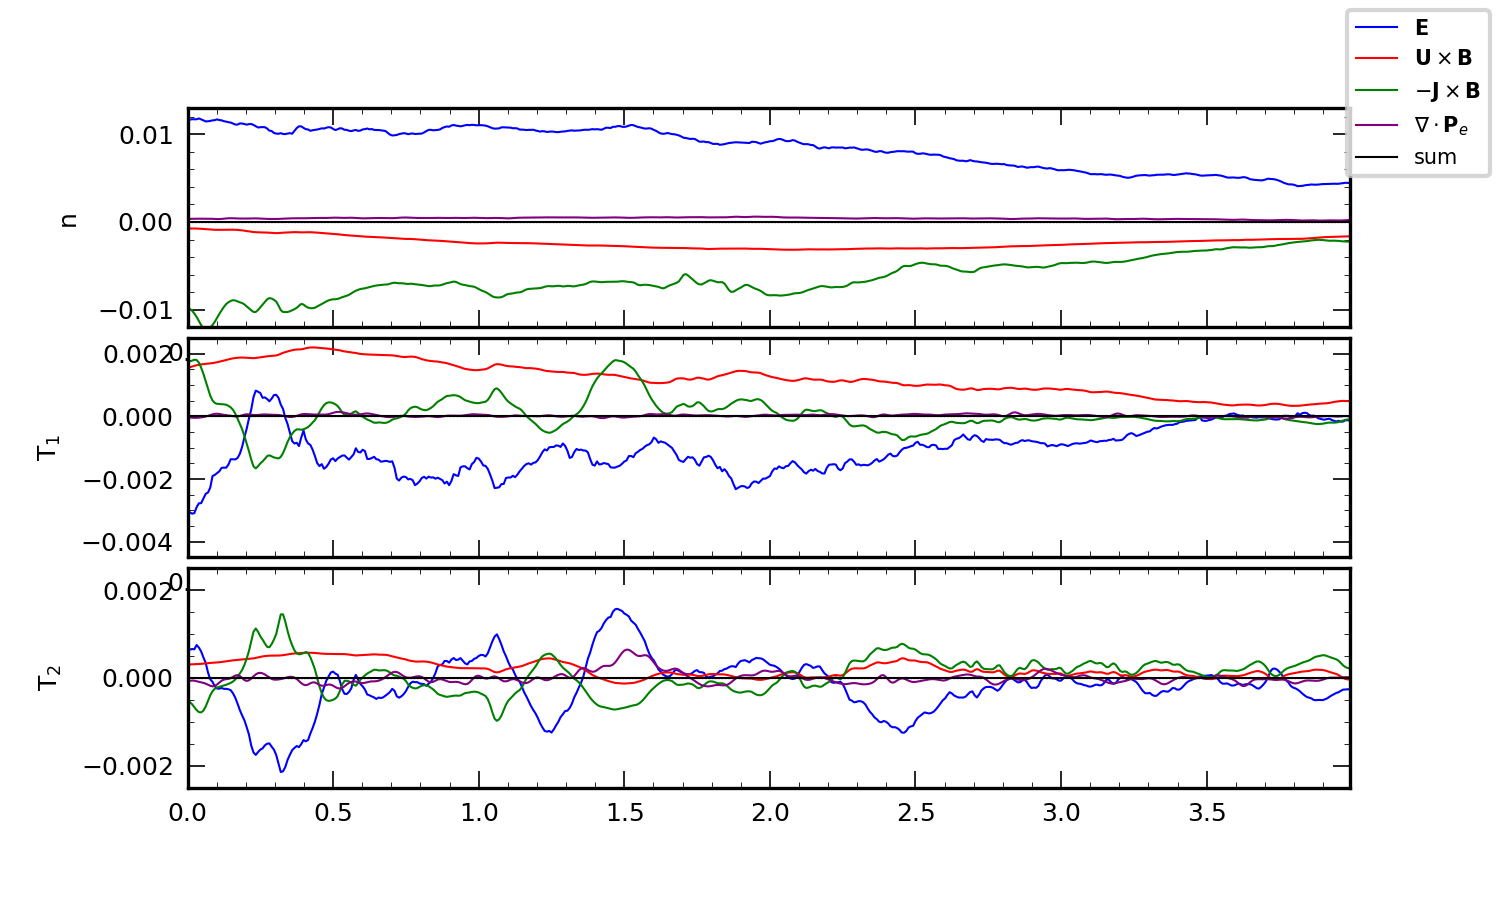

In [16]:
JxB_nxy=np.zeros((3,N)) #ordine in cui sono scritte
E_nxy=np.zeros((3,N)) #ordine in cui sono scritte
UxB_nxy=np.zeros((3,N)) #ordine in cui sono scritte
divPe_nxy=np.zeros((3,N)) #ordine in cui sono scritte
for t in nrangez:
    eyt1=-np.cross(ex,n_B[:,t])
    eyt1=eyt1/nplin.norm(eyt1)
    ext1=np.cross(eyt1,n_B[:,t])
    ext1=ext1/nplin.norm(ext1)

    
    E_nxy[0,t]=np.dot(E_Ohm[:,t], n_B[:,t])
    E_nxy[1,t]=np.dot(E_Ohm[:,t], ext1)
    E_nxy[2,t]=np.dot(E_Ohm[:,t], eyt1)
    JxB_nxy[0,t]=np.dot(JcrossB[:,t], n_B[:,t])
    JxB_nxy[1,t]=np.dot(JcrossB[:,t], ext1)
    JxB_nxy[2,t]=np.dot(JcrossB[:,t], eyt1)
    UxB_nxy[0,t]=np.dot(UcrossB[:,t], n_B[:,t])
    UxB_nxy[1,t]=np.dot(UcrossB[:,t], ext1)
    UxB_nxy[2,t]=np.dot(UcrossB[:,t], eyt1)

    divPe_nxy[0,t]=np.dot(divPemean[:,t], n_B[:,t])
    divPe_nxy[1,t]=np.dot(divPemean[:,t], ext1)
    divPe_nxy[2,t]=np.dot(divPemean[:,t], eyt1)

fig = plt.figure(figsize=[5,3])
titles=['n','T$_1$','T$_2$']

limits_Ohm1=[-0.012, -0.0045, -0.0025]
limits_Ohm2=[0.013, 0.0025, 0.0025]

for i in range(3):
    ax0 =plt.subplot(3,1,i+1)
    plt.ylabel(titles[i])
    plt.plot(trangez, E_nxy[i,nrangez], color='blue', label='$\\mathbf{E}$', lw=0.5)
    plt.plot(trangez, UxB_nxy[i,nrangez], color='red', label='$\\mathbf{U}\\times\mathbf{B}$', lw=0.5)
    plt.plot(trangez, -JxB_nxy[i,nrangez], color='green', label='$-\\mathbf{J}\\times\mathbf{B}$', lw=0.5)

    plt.plot(trangez, divPe_nxy[i,nrangez], color='purple', label='$\\nabla\cdot\mathbf{P}_e$', lw=0.5)
    plt.plot(trangez, Tsum_nxy[i,nrangez], color='black', label='sum', lw=0.5)

    plt.xlim([trangez5[0], trangez5[-1]])
    plt.ylim([limits_Ohm1[i], limits_Ohm2[i]])
    plt.axhline(y = 0, color = 'black', linestyle = ':') 
plt.subplots_adjust(hspace=.05)
 
handles, labels = ax0.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

/tmp/ipykernel_49287/344305575.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[i,1], sharex = ax0)
/tmp/ipykernel_49287/344305575.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0])
/tmp/ipykernel_49287/344305575.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[i,0], sharex = ax0)


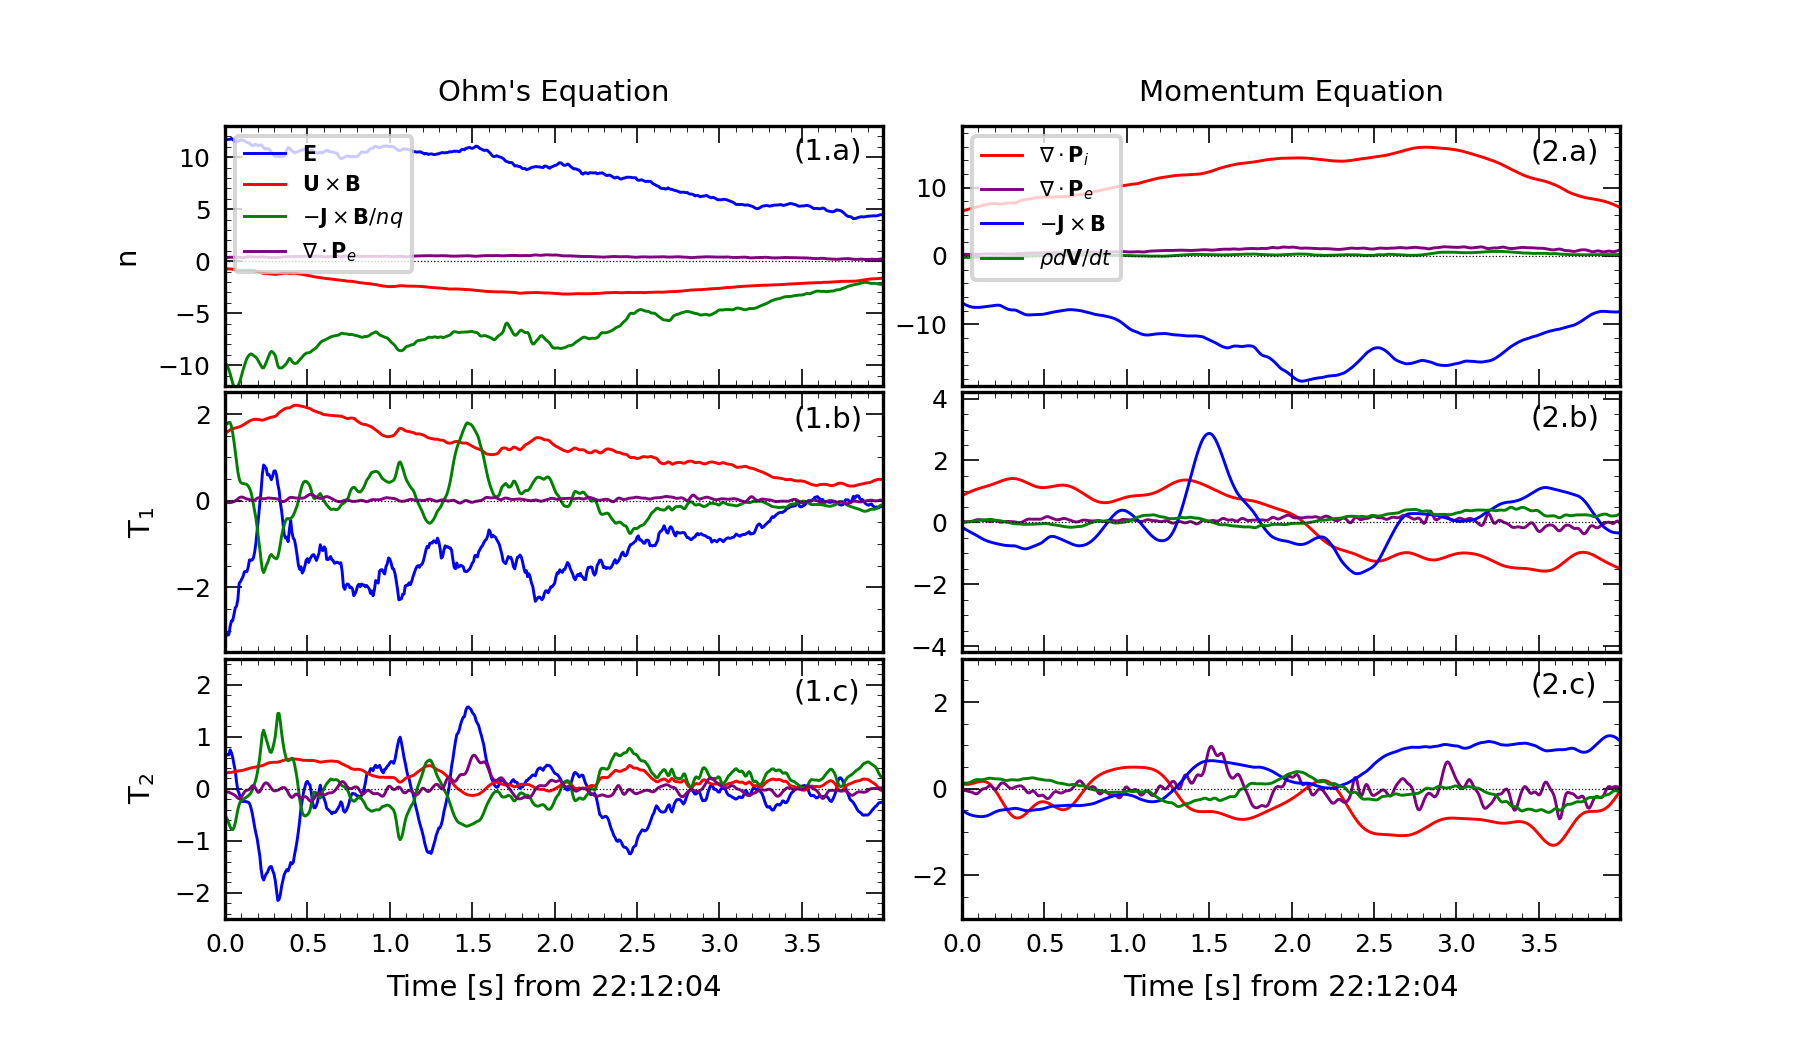

In [17]:
fig, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=[6,3.5])
titles=['n','T$_1$','T$_2$']
gs = gridspec.GridSpec(3, 2) 
limits=[1.9e-14, 4.2e-15, 3e-15]
for i in [2,1,0]:#range(3):
    ax0 = plt.subplot(gs[i,1], sharex = ax0)
    i1,=plt.plot(trangez, Momentum1[i,nrangez]*1e15, color='red', label='$\\nabla\cdot\mathbf{P}_i$', lw=0.7)
    i2,=plt.plot(trangez, Momentum2[i,nrangez]*1e15, color='purple', label='$\\nabla\cdot\mathbf{P}_e$', lw=0.7)
    i3,=plt.plot(trangez, Momentum3[i,nrangez]*1e15, color='blue', label='$-\\mathbf{J}\\times \mathbf{B}$', lw=0.7)
    i4,=plt.plot(trangez, Momentum4[i,nrangez]*1e15, color='green', label='$mn d\\mathbf{V}/dt$', lw=0.7)
    plt.axhline(y = 0, color = 'black', linestyle = ':')
    plt.xlim([trangez5[0], trangez5[-1]])
    #ax0.xaxis.set_visible(False)
    if i in [0,1]:
        plt.setp(ax0.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Time [s] from 22:12:04', fontsize=7)
    plt.ylim([-limits[i]*1e15, limits[i]*1e15])

    if i==0:
        ax0.set_title('Momentum Equation', fontsize=7)
        plt.text(3.45, 14., '(2.a)', fontdict=None, fontsize=7)
    if i==1:
        plt.text(3.45, 3.1, '(2.b)', fontdict=None, fontsize=7)
    if i==2:
        plt.text(3.45, 2.2, '(2.c)', fontdict=None, fontsize=7)

plt.subplots_adjust(hspace=.025)
plt.subplots_adjust(wspace=.12)
ax0 = plt.subplot(gs[0])

#ax0.xaxis.set_visible(True)
ax0 = plt.subplot(gs[0,1])
plt.legend([i1, i2, i3, i4],["$\\nabla\cdot\mathbf{P}_i$", "$\\nabla\cdot\mathbf{P}_e$", "$-\\mathbf{J}\\times \mathbf{B}$", "$\\rho d\\mathbf{V}/dt$"], loc='upper left')


limits_Ohm1=[-0.012, -0.0035, -0.0025]
limits_Ohm2=[0.013, 0.0025, 0.0025]

for i in [2,1,0]:
    ax0 = plt.subplot(gs[i,0], sharex = ax0)
    ax0.set_ylabel(titles[i], fontsize=7)
    i1,=plt.plot(trangez, E_nxy[i,nrangez]*1e3, color='blue', label='$\\mathbf{E}$', lw=0.7)
    i2,=plt.plot(trangez, UxB_nxy[i,nrangez]*1e3, color='red', label='$\\mathbf{U}\\times\mathbf{B}$', lw=0.7)
    i3,=plt.plot(trangez, -JxB_nxy[i,nrangez]*1e3, color='green', label='$-\\mathbf{J}\\times\mathbf{B}$', lw=0.7)

    i4,=plt.plot(trangez, divPe_nxy[i,nrangez]*1e3, color='purple', label='$\\nabla\cdot\mathbf{P}_e$', lw=0.7)
    #i5,=plt.plot(trangez, Tsum_nxy[i,nrangez]*1e3, color='black', label='sum', lw=0.5, ls=':')

    plt.xlim([trangez5[0], trangez5[-1]])
    plt.ylim([limits_Ohm1[i]*1e3, limits_Ohm2[i]*1e3])
    plt.axhline(y = 0, color = 'black', linestyle = ':')
    if i in [0,1]:
        plt.setp(ax0.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Time [s] from 22:12:04', fontsize=7)
    if i==0:
        ax0.set_title('Ohm\'s Equation', fontsize=7)
        plt.text(3.45, 9.8, '(1.a)', fontdict=None, fontsize=7)
    if i==2:
        ax0.set_title('Ohm\'s Equation', fontsize=7)
        plt.text(3.45, 1.7, '(1.c)', fontdict=None, fontsize=7)
    if i==1:
        ax0.set_title('Ohm\'s Equation', fontsize=7)
        plt.text(3.45, 1.7, '(1.b)', fontdict=None, fontsize=7)
ax0 = plt.subplot(gs[0,0])
plt.legend([i1, i2, i3, i4],["$\\mathbf{E}$", "$\\mathbf{U}\\times\mathbf{B}$", "$-\\mathbf{J}\\times\mathbf{B}/nq$", "$\\nabla\cdot\mathbf{P}_e$"], loc='upper left')
plt.show()